# Consolidated Micro Price Data

Daily prices are obtained for the US, Argentina, Brazil, Colombia, and Chile.

Dates: 2007 to 2010.

Data obtained from the Billion Prices Project. Available at the dataverse page for Online Micro Price Data, https://dataverse.harvard.edu/dataset.xhtml?persistentId=doi%3A10.7910%2FDVN%2FIAH6Z6.

In [1]:
import numpy as np
import pandas as pd
import scipy.stats as st
import statsmodels as sm
from scipy.special import factorial
from scipy.optimize import curve_fit
from scipy.stats import chisquare
import warnings
warnings.filterwarnings('ignore')

import matplotlib
import matplotlib.pyplot as plt
matplotlib.rcParams['figure.figsize'] = (8, 6)
matplotlib.style.use('ggplot')

In [2]:
# Define lists of datasets and countries

datasets = ["../Data/usa1.dta","../Data/usa2.dta","../Data/argentina.dta","../Data/brazil.dta","../Data/chile.dta","../Data/colombia.dta"]

country = ["USA Supermarket","USA Department Store","Argentina","Brazil","Chile","Colombia"]

# Load the datasets

for (filename,cntry) in zip(datasets,country):
    data = pd.read_stata(filename)
    print(cntry)
    print(data.head())
    print()
       

USA Supermarket
   id  cat_url  bppcat       date  miss  price0  price  nsprice  sale  \
0   1   1968.0     118 2008-05-08   NaN     2.0    2.0      2.0   NaN   
1   1   1968.0     118 2008-05-09   NaN     2.0    2.0      2.0   NaN   
2   1   1968.0     118 2008-05-10   1.0     NaN    NaN      NaN   NaN   
3   1   1968.0     118 2008-05-11   NaN     2.0    2.0      2.0   NaN   
4   1   1968.0     118 2008-05-12   NaN     2.0    2.0      2.0   NaN   

   fullprice  nsfullprice  fullsale  initialspell  lastspell  category  
0        2.0          2.0       NaN           1.0        NaN     118.0  
1        2.0          2.0       NaN           1.0        NaN     118.0  
2        2.0          2.0       NaN           NaN        NaN     118.0  
3        2.0          2.0       NaN           NaN        NaN     118.0  
4        2.0          2.0       NaN           NaN        NaN     118.0  

USA Department Store
   id  cat_url  bppcat       date  miss  price0      price    nsprice  sale  \
0  75 

In [3]:
# NaN check

for (filename,cntry) in zip(datasets,country):
    data = pd.read_stata(filename)
    print(cntry)
    print("Percentage of NaN in the data:\n")
    print(data.isnull().sum()/len(data))
    print()
    
print("\nWe will use 'nsfullprice' as our price data.")


USA Supermarket
Percentage of NaN in the data:

id              0.000000
cat_url         0.000000
bppcat          0.000000
date            0.000000
miss            0.747364
price0          0.252636
price           0.252636
nsprice         0.252636
sale            0.958572
fullprice       0.014395
nsfullprice     0.014395
fullsale        0.911097
initialspell    0.968245
lastspell       0.959472
category        0.000000
dtype: float64

USA Department Store
Percentage of NaN in the data:

id              0.000000
cat_url         0.000000
bppcat          0.000000
date            0.000000
miss            0.621459
price0          0.378541
price           0.378541
nsprice         0.378541
sale            0.998586
fullprice       0.008994
nsfullprice     0.008994
fullsale        0.994519
initialspell    0.954378
lastspell       0.953015
category        0.000000
dtype: float64

Argentina
Percentage of NaN in the data:

id              0.000000
cat_url         0.000000
bppcat          0.000000


In [4]:
# Function restricts dataset to products that have at least 100 days of data

def at_least_n_days(df, n=100):
    """ Use auxiliary dataset to find id's that have at least n days of data. """
    aux = df.groupby(by='id').count()
    aux = aux[aux['nsfullprice'] > n]
    df = df[df.id.isin(aux.index)]
    return df

# Drop outliers. Definition below, following Cavallo (2018)

def drop_outliers(df):
    df = df[df['log_change'] < 2]  # drop price changes > 200%
    df = df[df['log_change'] > -.7]  # drop price changes < -70%
    return df


In [5]:
# Calculate percentage change of prices

def set_log_change_col(df):
    """ Create price 'log_change' column for each product id. """
    df.sort_values(['id', 'date'], inplace=True)
    gb = df.groupby(['id'])['nsfullprice']
    df['log_change'] = gb.transform(lambda x: np.log(x).diff())
    df.sort_index(inplace=True)
    df = drop_outliers(df)
    return df


In [6]:
# Creates positive/negative/neutral price changes 

def create_directions(df):
    df['Positive'] = np.where(df['log_change'] > 0, df['log_change'], None)
    df['Neutral'] = np.where(df['log_change'] == 0, df['log_change'], None)
    df['Negative'] = np.where(df['log_change'] < 0, df['log_change'], None)
    return df

def basic_numbers(df):
    """ Print number of observations for positive, neutral, and negative price changes. 
    And their respective percentages."""
    pos = df[df['log_change']>0]
    neg = df[df['log_change']<0]
    
    p = len(pos)
    n = len(neg)
    total = len(df['log_change'])
    
    print("Number of positive price changes: ", p)
    print("Number of negative price changes: ", n)  
       
    print("Percentage of positive price changes: ", p/(p+n))
    print("Percentage of negative price changes: ", n/(p+n))
    
    return pos, neg

In [7]:
# Function that carries our data analysis for any given country.

def data_analysis(df, country):
         
    # 1. Set data range.
    
    df['date'] = pd.to_datetime(df['date'])
    
    # 2. Restrict dataset to useful variables. Drop NAs
    
    df = df[["date","id","nsfullprice"]]
    df = df.dropna()
      
    # 3. Restrict data to products with at least 100 days of data
    
    df = at_least_n_days(df, n=100)
        
    date_range = df.date.max() - df.date.min()
    n_days = date_range.days
        
    n_products = len(df.id.unique())
    
    # 4. Add percentage log changes, and directions of price change
    
    daily = set_log_change_col(df)  
    basic_pos, basic_neg = basic_numbers(daily)
            
    n_neg_chgs = len(basic_neg)
    n_neg_prod = len(basic_neg.id.unique())
    
    # create direction columns
    daily = create_directions(daily)
    daily['neg'] = np.where(daily['Negative']<0,1,0)
    daily['neg'] = daily.groupby('Negative').neg.transform('sum')
    neg_onedays = len(daily[daily['neg']==1].date.unique())
    neg_days = len(daily[daily['neg']>0].date.unique())
    neg_zerodays = len(daily[daily['neg']==0].date.unique())
    print("Number of days with a negative price change", neg_days)
    print("Number of days with zero price changes ", neg_zerodays)

    # 5. Median log price increase
    
    daily_neg = daily[daily['log_change']<0]
    
    print("n_prods_neg", len(daily_neg.id.unique()))
    stats_neg = daily_neg['log_change'].describe()
    print("Median negative price change: ", daily_neg['log_change'].median())

    # 6. Count how many changes in prices per day
    
    gb_date1 = daily.groupby('date')['Positive', 'Neutral', 'Negative'].count()
    
    
    # 7. Define avalanches -- conditional on a price change
 
    print(gb_date1['Negative'].describe())
    gb_date1['Negative_shift'] = gb_date1['Negative'].transform(lambda x: x-1)
    
    #Positive price changes only
    gb_date2 = gb_date1[gb_date1['Negative_shift']>-1]
    
    # Positive price changes histogram
    fig, ax1 = plt.subplots(figsize=(7,5))
    ax1.set_title(country)
    ax1.set_xlabel("Number of negative changes in a day (-1)")
    ax1.set_ylabel("Number of days \n with a given number of negative changes")
    ax1.hist(gb_date2['Negative_shift'], bins=100)
    plt.show()
    
    print(gb_date2['Negative_shift'].describe())
    gb_date2 = gb_date2[gb_date2['Negative_shift']<143]
    fig, ax1 = plt.subplots(figsize=(7,5))
    ax1.set_title(country)
    ax1.set_xlabel("Number of negative changes in a day (-1)")
    ax1.set_ylabel("Number of days \n with a given number of negative changes")
    ax1.hist(gb_date2['Negative_shift'], bins=100)
    fig.savefig("../figs/{}_negpricechanges.pdf".format(country), bbox_inches='tight')
    plt.show()
    
    # 8. Counter CDF plot
    
    x = np.linspace(1, 142, 142)
    F_x = np.zeros_like(x)

    total = gb_date1['Negative_shift'][gb_date1['Negative_shift']>-1].count()
    for i in range(len(x)):
        F_x[i] = gb_date1['Negative_shift'][gb_date1['Negative_shift'] > x[i]].count() / total
    
    # 9. Fitting a GPD to the counter CDF plot

    def pr(x, a, b):
        pdf = ((a*x + b)**(x-1)) * np.exp(-(a*x + b)) * b / factorial(x)
        pdf0 = (b**(-1)) * np.exp(-b) * b
        ctr_cdf = 1-(np.cumsum(pdf)+pdf0)
        return np.log(ctr_cdf)

    popt, pcov = curve_fit(pr, x, np.log(F_x),bounds=(0,[1,25]))
    print(*popt)
    print("Normalized RMSE", (np.sqrt(np.mean((F_x-np.exp(pr(x, popt[0],popt[1])))**2)))/np.mean(F_x) )

    print("Optimal values of the parameters:")
    print("theta =", popt[0])
    print("theta0 =", popt[1])
    print("Cov(theta,theta0) = ", pcov)

    # calculate p-value
    test_statistics = popt[0]/pcov[0,0]
    test_p_value = st.norm.cdf(-test_statistics)
    print("p-value for theta: ", test_p_value)

    test_statistics = popt[1]/pcov[1,1]
    test_p_value = st.norm.cdf(-test_statistics)
    print("p-value for theta0: ", test_p_value)
    
    fig, ax = plt.subplots(figsize=(7,5))
    ax.plot(np.log(x), np.log(F_x), label="Data")
    ax.plot(np.log(x), pr(x, popt[0], popt[1]), label="Fit")
    ax.set_ylabel("log(1-F(x))")
    ax.set_xlabel("log(x)")
    ax.legend()
    fig.savefig("../figs/{}_negcounter.pdf".format(country), bbox_inches='tight')

    # Counter-cumulative data vs fit
    fig, [ax2,ax3] = plt.subplots(nrows=1, ncols=2, figsize=(15,5))
    ax2.plot(np.log(x), np.log(F_x), label="Data")
    ax2.plot(np.log(x), pr(x, popt[0], popt[1]), label="Fit")
    ax2.set_ylabel("log(1-F(x))")
    ax2.set_xlabel("log(x)")
    ax2.legend()
    
    
    # Get data restricted to our x
    
    d = gb_date1['Negative_shift'][gb_date1['Negative_shift']>-1]
    quan = d.quantile(0.33)
    quan = quan.item()
    quan = int(quan)
    print("Quantile: ", quan)
    d = d[d<143]
    d = d[d>=quan]
    x = np.linspace(quan, 142, 143 - quan)
    
    # 10. Chi-square goodness-of-fit test for discrete distributions

    # Generate data according to the Generalized Poisson distribution
    def rgpd(x, a, b):
        # a is theta, b is theta0
        px = ((a*x + b)**(x-1)) * np.exp(-(a*x + b)) * b / factorial(x)
        return px

    expected_values = rgpd(x, popt[0], popt[1])
    expected_values = expected_values/expected_values.sum()
    
    gb_date1 = gb_date1[gb_date1['Negative_shift']>=quan]
    number = gb_date1['Negative_shift'][gb_date1['Negative_shift']<143].count()
    expected_values = number*expected_values
    
    
    # Density vs histogram frequency
    aux = ax3.hist(d, bins=len(x), density=False, label="Observed")
    ax3.plot(x,expected_values, label="Expected")
    ax3.legend()
    ax3.set_xlabel("x")
    ax3.set_ylabel("Density")
    extent = ax3.get_window_extent().transformed(fig.dpi_scale_trans.inverted())
    # Pad the saved area by 10% in the x-direction and 20% in the y-direction
    plt.tight_layout()
    
    sty = fig.suptitle(country, fontsize="x-large")
    sty.set_y(0.95)
    fig.subplots_adjust(top=0.85)
    fig.savefig("../figs/{}neg.pdf".format(country), bbox_inches='tight')
    plt.show()
    
    fig, ax4 = plt.subplots(figsize=(7,5))
    ax4.hist(d, bins=len(x), density=False, label="Observed")
    ax4.plot(x,expected_values, label="Expected")
    ax4.legend()
    ax4.set_xlabel("x")
    ax4.set_ylabel("Density")
    fig.savefig("../figs/{}_neghist.pdf".format(country), bbox_inches='tight')
    plt.show()
    
    observed_values = aux[0]

    # Chi-square test:
    # H0: data follows GPD 
    # H1: data does not follow GPD
    # hence, our results are good if we do NOT reject the null hypothesis (i.e. p-value>0.05). 

    chi_sq, p_value = chisquare(observed_values, f_exp=expected_values)
    print("p_value for chi-square test: ", p_value)
    
    return popt[0], popt[1], n_days, n_products
    # price median, price median adjusted by pos vs neg, dataset inflation, annual inflation
    # theta, theta0, # days, # products, lambda+mu
   

USA Supermarket
Number of positive price changes:  91795
Number of negative price changes:  76618
Percentage of positive price changes:  0.5450588731273714
Percentage of negative price changes:  0.4549411268726286
Number of days with a negative price change 714
Number of days with zero price changes  0
n_prods_neg 17311
Median negative price change:  -0.20909184217453003
count     814.000000
mean       94.125307
std       128.848096
min         0.000000
25%        16.000000
50%        37.500000
75%       124.750000
max      1099.000000
Name: Negative, dtype: float64


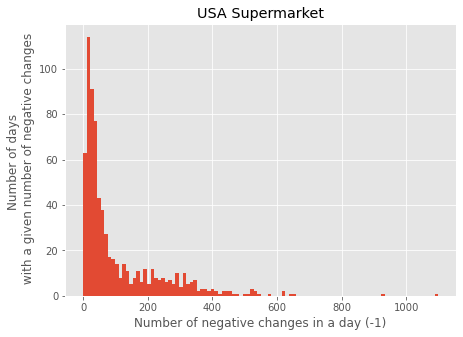

count     714.000000
mean      106.308123
std       132.339231
min         0.000000
25%        22.000000
50%        47.500000
75%       149.750000
max      1098.000000
Name: Negative_shift, dtype: float64


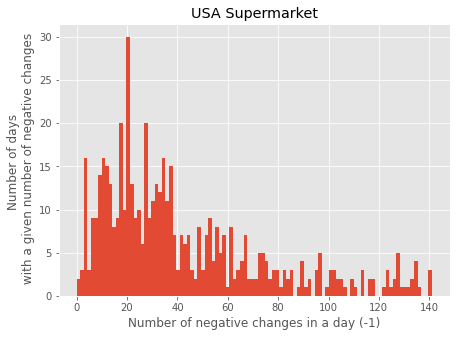

0.9604069859475521 5.871661071744254
Normalized RMSE 0.045128218237346224
Optimal values of the parameters:
theta = 0.9604069859475521
theta0 = 5.871661071744254
Cov(theta,theta0) =  [[ 1.51451930e-06 -6.64926422e-05]
 [-6.64926422e-05  3.26540864e-03]]
p-value for theta:  0.0
p-value for theta0:  0.0
Quantile:  29


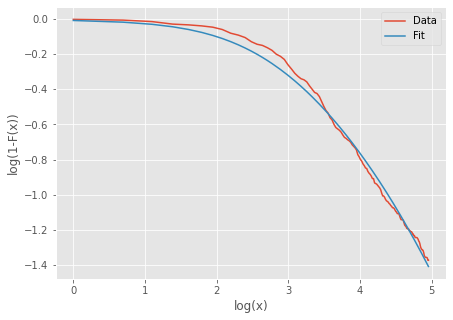

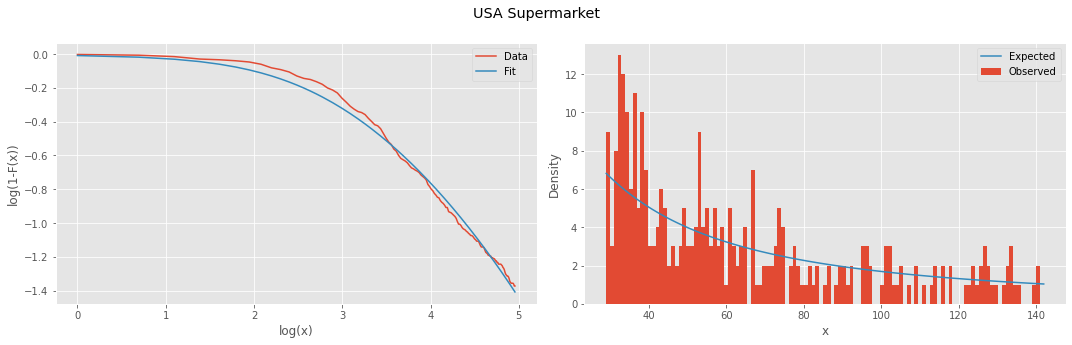

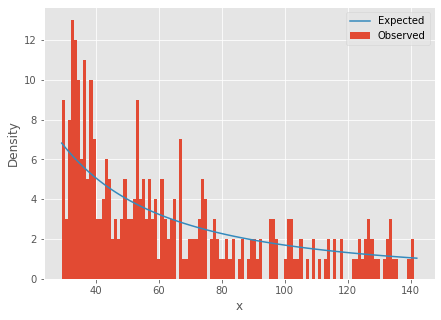

p_value for chi-square test:  0.49454079634139275

USA Department Store
Number of positive price changes:  24752
Number of negative price changes:  46495
Percentage of positive price changes:  0.3474111190646624
Percentage of negative price changes:  0.6525888809353376
Number of days with a negative price change 698
Number of days with zero price changes  0
n_prods_neg 22644
Median negative price change:  -0.1779789924621582
count     865.000000
mean       53.751445
std        99.522957
min         0.000000
25%         3.000000
50%        23.000000
75%        61.000000
max      1227.000000
Name: Negative, dtype: float64


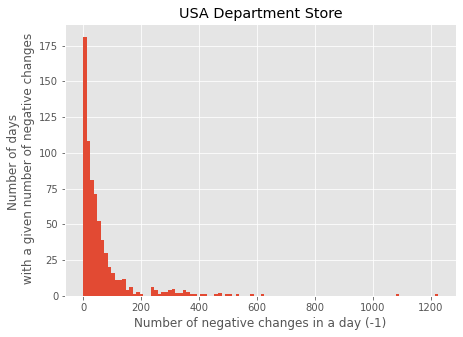

count     698.000000
mean       65.611748
std       106.864962
min         0.000000
25%        12.000000
50%        32.500000
75%        71.000000
max      1226.000000
Name: Negative_shift, dtype: float64


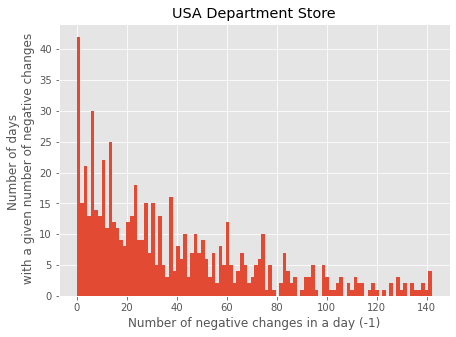

0.9047944381478059 5.66211795652543
Normalized RMSE 0.055051849806464
Optimal values of the parameters:
theta = 0.9047944381478059
theta0 = 5.66211795652543
Cov(theta,theta0) =  [[ 5.71722796e-07 -2.79850349e-05]
 [-2.79850349e-05  1.54815919e-03]]
p-value for theta:  0.0
p-value for theta0:  0.0
Quantile:  18


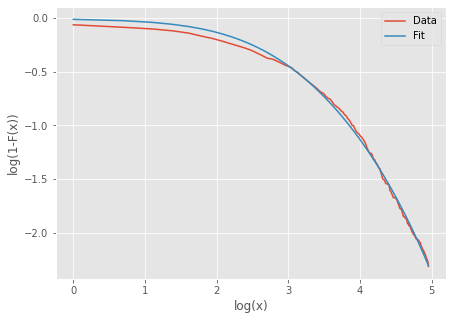

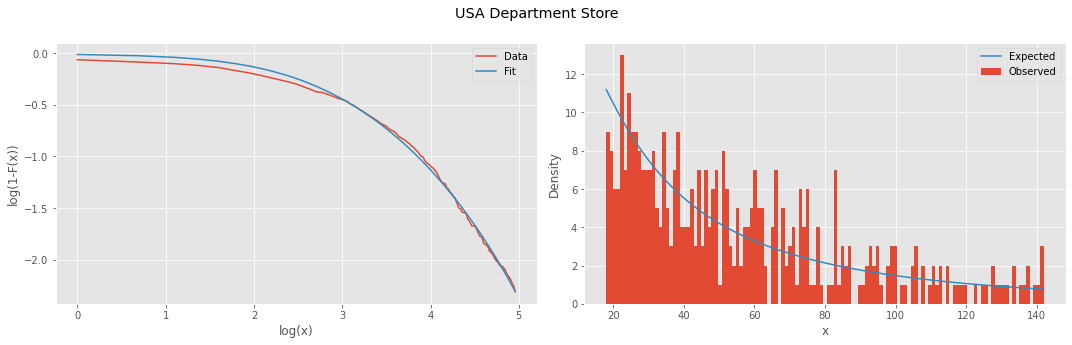

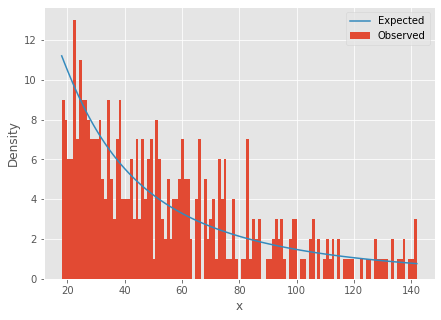

p_value for chi-square test:  0.3763545745202587

Argentina
Number of positive price changes:  116241
Number of negative price changes:  27809
Percentage of positive price changes:  0.8069489760499826
Percentage of negative price changes:  0.19305102395001736
Number of days with a negative price change 859
Number of days with zero price changes  0
n_prods_neg 13924
Median negative price change:  -0.057084083557128906
count    1041.000000
mean       26.713737
std       175.173279
min         0.000000
25%         2.000000
50%        11.000000
75%        23.000000
max      5332.000000
Name: Negative, dtype: float64


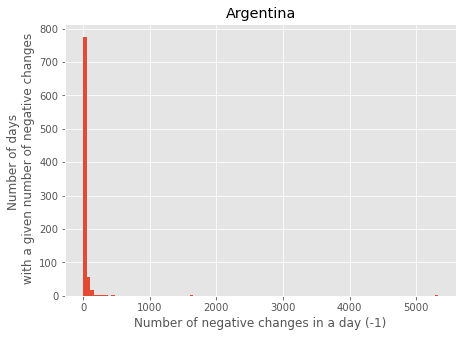

count     859.000000
mean       31.373690
std       192.383247
min         0.000000
25%         6.000000
50%        14.000000
75%        27.000000
max      5331.000000
Name: Negative_shift, dtype: float64


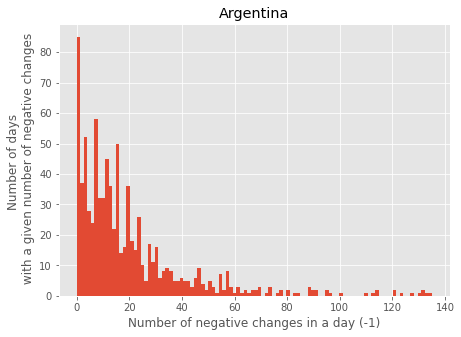

0.8604943775612965 3.046920177040435
Normalized RMSE 0.20070104440301048
Optimal values of the parameters:
theta = 0.8604943775612965
theta0 = 3.046920177040435
Cov(theta,theta0) =  [[ 1.74135894e-06 -6.24500422e-05]
 [-6.24500422e-05  2.63888325e-03]]
p-value for theta:  0.0
p-value for theta0:  0.0
Quantile:  8


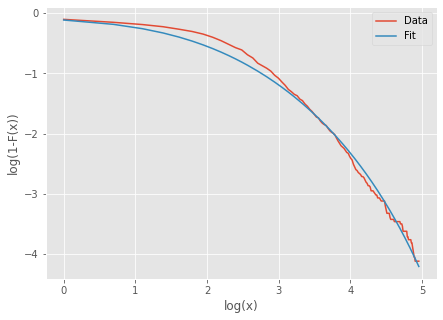

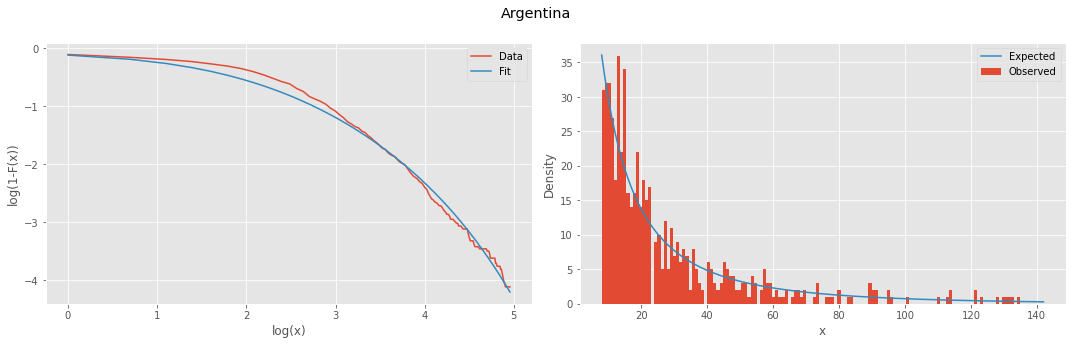

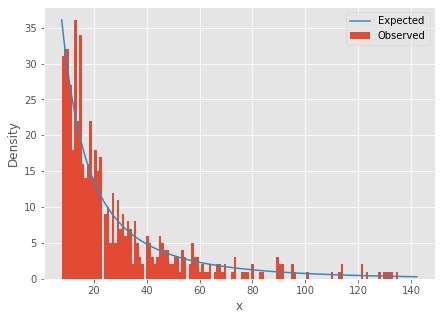

p_value for chi-square test:  0.254904528701302

Brazil
Number of positive price changes:  152580
Number of negative price changes:  102952
Percentage of positive price changes:  0.5971072116212451
Percentage of negative price changes:  0.4028927883787549
Number of days with a negative price change 854
Number of days with zero price changes  0
n_prods_neg 16494
Median negative price change:  -0.08246850967407227
count    1026.000000
mean      100.343080
std       313.776169
min         0.000000
25%         5.000000
50%        56.500000
75%       127.000000
max      9012.000000
Name: Negative, dtype: float64


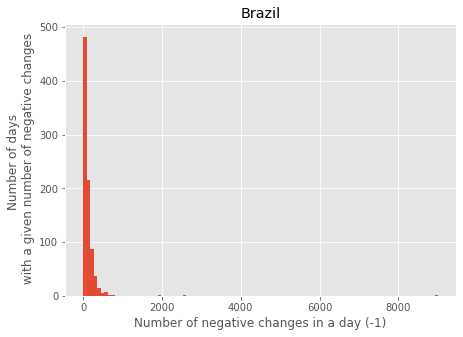

count     854.000000
mean      119.552693
std       340.395348
min         0.000000
25%        26.000000
50%        76.000000
75%       143.750000
max      9011.000000
Name: Negative_shift, dtype: float64


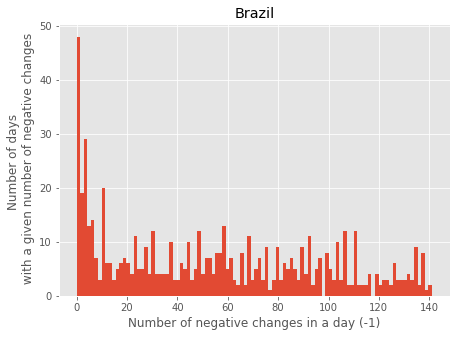

0.9351001461069987 8.456523294036659
Normalized RMSE 0.08674865557318406
Optimal values of the parameters:
theta = 0.9351001461069987
theta0 = 8.456523294036659
Cov(theta,theta0) =  [[ 6.27698673e-06 -3.73026038e-04]
 [-3.73026038e-04  2.42925329e-02]]
p-value for theta:  0.0
p-value for theta0:  0.0
Quantile:  43


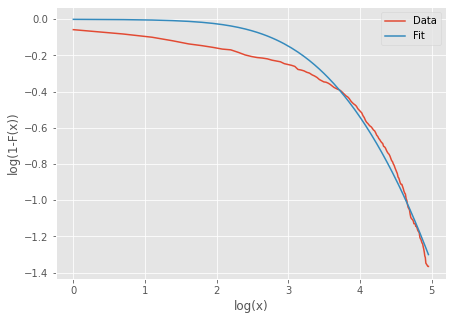

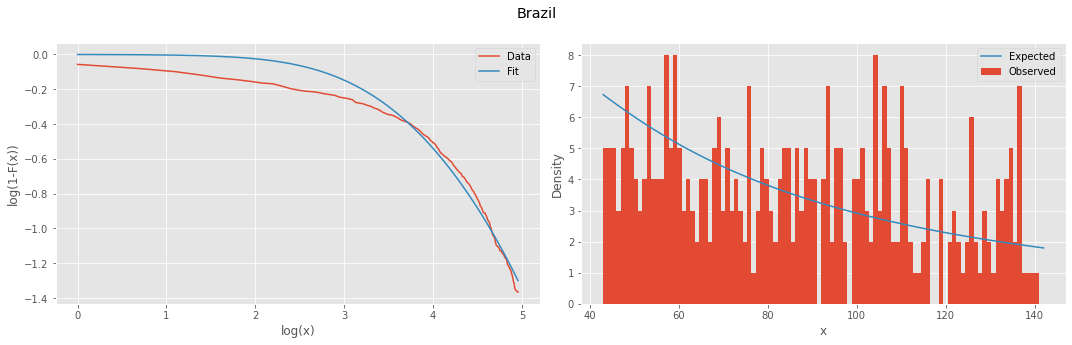

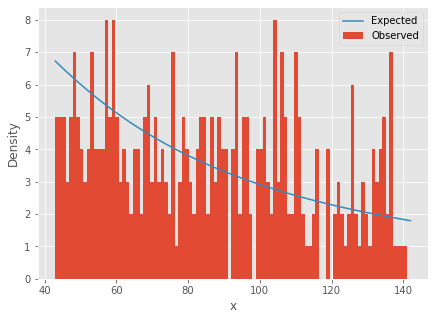

p_value for chi-square test:  0.06483841091789709

Chile
Number of positive price changes:  70755
Number of negative price changes:  50096
Percentage of positive price changes:  0.5854730204963137
Percentage of negative price changes:  0.41452697950368633
Number of days with a negative price change 730
Number of days with zero price changes  0
n_prods_neg 11406
Median negative price change:  -0.0694723129272461
count    1024.000000
mean       48.921875
std        92.164521
min         0.000000
25%         0.000000
50%        20.000000
75%        66.000000
max      1401.000000
Name: Negative, dtype: float64


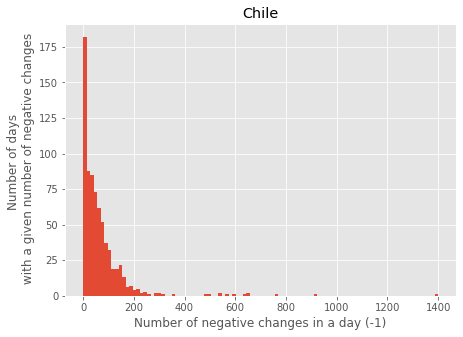

count     730.000000
mean       67.624658
std       102.791205
min         0.000000
25%        14.000000
50%        42.500000
75%        86.000000
max      1400.000000
Name: Negative_shift, dtype: float64


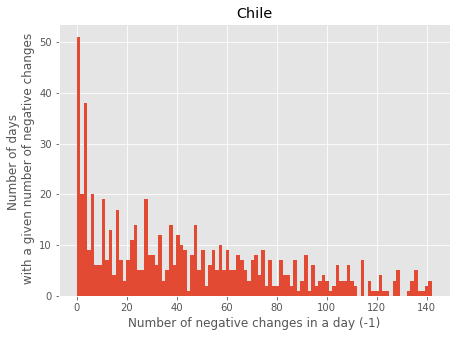

0.8910434293393005 7.260900233619782
Normalized RMSE 0.11434564052651748
Optimal values of the parameters:
theta = 0.8910434293393005
theta0 = 7.260900233619782
Cov(theta,theta0) =  [[ 2.24081705e-06 -1.31390470e-04]
 [-1.31390470e-04  8.56965106e-03]]
p-value for theta:  0.0
p-value for theta0:  0.0
Quantile:  23


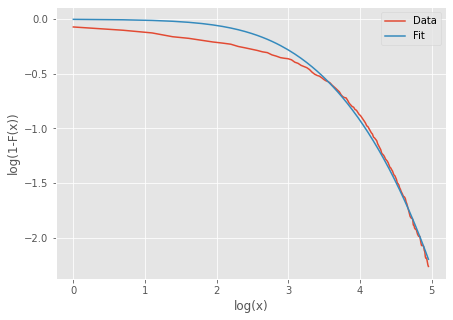

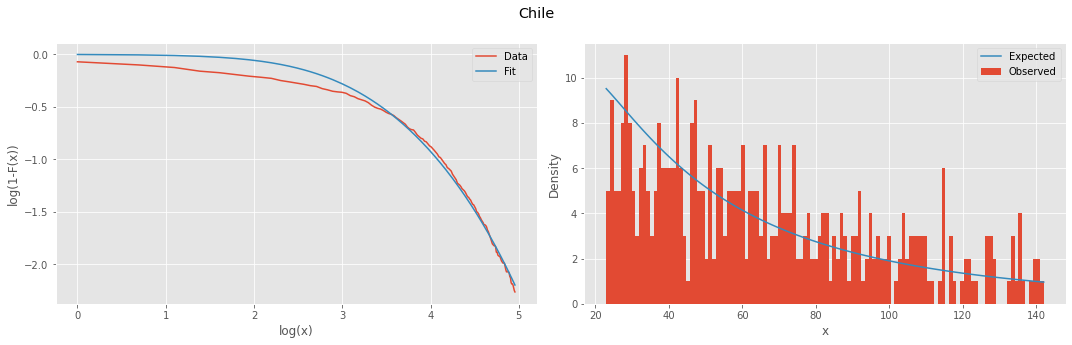

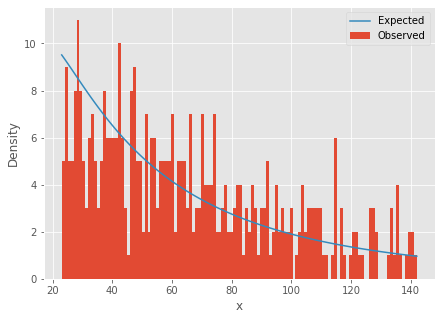

p_value for chi-square test:  0.3816029074905318

Colombia
Number of positive price changes:  47699
Number of negative price changes:  34508
Percentage of positive price changes:  0.5802303940053767
Percentage of negative price changes:  0.4197696059946233
Number of days with a negative price change 788
Number of days with zero price changes  0
n_prods_neg 6667
Median negative price change:  -0.06415414810180664
count    992.000000
mean      34.786290
std       43.684779
min        0.000000
25%        3.000000
50%       23.000000
75%       49.000000
max      405.000000
Name: Negative, dtype: float64


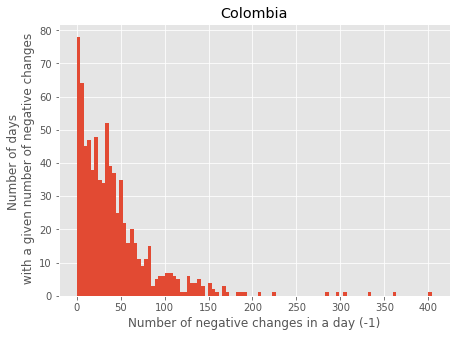

count    788.000000
mean      42.791878
std       44.812469
min        0.000000
25%       13.000000
50%       33.000000
75%       54.000000
max      404.000000
Name: Negative_shift, dtype: float64


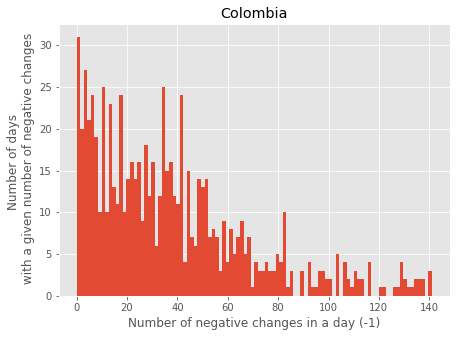

0.8456688341761703 6.687950055357627
Normalized RMSE 0.08246110094465088
Optimal values of the parameters:
theta = 0.8456688341761703
theta0 = 6.687950055357627
Cov(theta,theta0) =  [[ 7.93028313e-07 -4.77372424e-05]
 [-4.77372424e-05  3.22701009e-03]]
p-value for theta:  0.0
p-value for theta0:  0.0
Quantile:  19


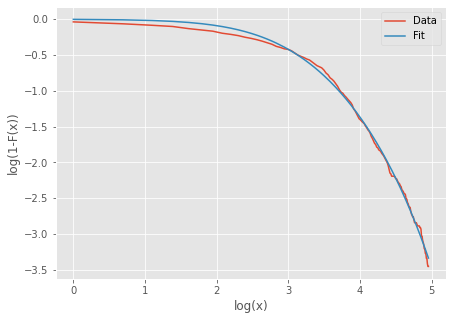

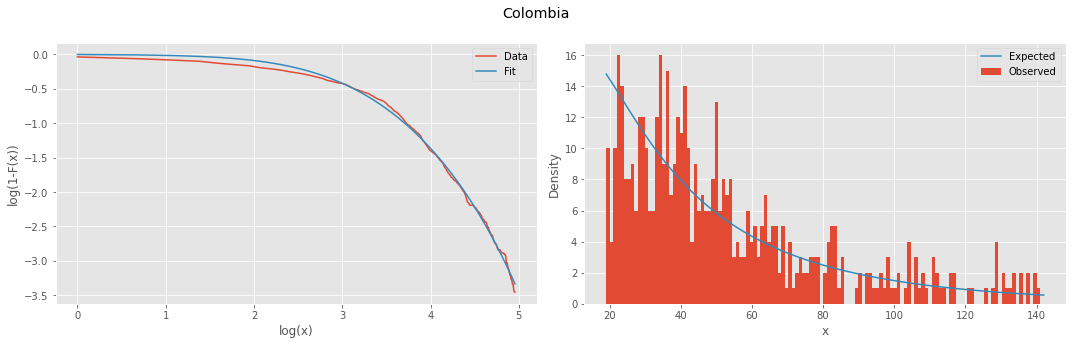

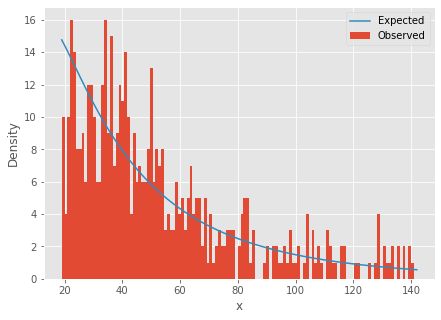

p_value for chi-square test:  0.05882853080634297



In [8]:
import statsmodels.formula.api as sm
df_estimated = pd.DataFrame(columns = ['theta', 'theta0', 
                                       'n_days', 'n_prods'], index = country)
    
for (filename,cntry) in zip(datasets,country):
    data = pd.read_stata(filename)
    print(cntry)
    
    df_estimated.loc[cntry] = data_analysis(data, cntry)
    print()
     